In [6]:
import numpy as np
import time
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from renormalization_np import track_rg_flow

def analyze_coefficients_vs_M_parallel(M_values, J=0.0, n_max=20, n_steps=50, b=2, d=2, n_workers=None):
    """
    Analyze coefficient behavior when varying M with fixed J value.
    
    Args:
        M_values: Array of M values to analyze
        J: Fixed J value to use (default 0.0 to look for M-based fixed-line behavior)
        n_max: Maximum Fourier mode
        n_steps: Number of RG steps
        b: Length rescaling factor
        d: Dimension
        n_workers: Number of workers for parallelization (default: None = auto)
    
    Returns:
        Dictionary with coefficient data
    """
    def process_single_M(M):
        """Process a single M value"""
        # Track the RG flow
        flow_history = track_rg_flow(J, J, M, b, d, n_max, n_steps)
        
        # Extract final coefficients
        final_coeffs = flow_history[-1]
        
        # Store key coefficients (real parts)
        coeffs = np.zeros(7)
        coeffs[0] = final_coeffs[n_max, n_max].real       # (0,0)
        coeffs[1] = final_coeffs[n_max+1, n_max].real     # (1,0)
        coeffs[2] = final_coeffs[n_max, n_max+1].real     # (0,1)
        coeffs[3] = final_coeffs[n_max+1, n_max+1].real   # (1,1)
        coeffs[4] = final_coeffs[n_max+2, n_max].real     # (2,0)
        coeffs[5] = final_coeffs[n_max, n_max+2].real     # (0,2)
        coeffs[6] = final_coeffs[n_max+2, n_max+2].real   # (2,2)
        
        # Calculate key ratios
        ratios = np.zeros(6)
        if abs(coeffs[0]) > 1e-10:
            ratios[0] = coeffs[1] / coeffs[0]  # (1,0)/(0,0)
            ratios[1] = coeffs[2] / coeffs[0]  # (0,1)/(0,0)
            ratios[2] = coeffs[3] / coeffs[0]  # (1,1)/(0,0)
            ratios[3] = coeffs[4] / coeffs[0]  # (2,0)/(0,0)
            ratios[4] = coeffs[5] / coeffs[0]  # (0,2)/(0,0)
            ratios[5] = coeffs[6] / coeffs[0]  # (2,2)/(0,0)
        
        # For J=0, use (2,2) and (1,1) ratio to estimate M_v
        M_v = np.nan
        if abs(coeffs[3]) > 1e-10 and abs(coeffs[6]) > 1e-10:
            ratio_11_22 = abs(coeffs[6] / coeffs[3])  # |(2,2)/(1,1)|
            
            if ratio_11_22 < 1:  # Normal decay pattern
                # Adjusted formula for M-based model
                M_v = -6 / (4 * np.log(ratio_11_22))
                
                # Calculate fixed-line matching score based on coefficient patterns
                # Rather than a simple deviation calculation, we can use a modified approach
                # that accounts for the observed behaviors
                
                return coeffs, ratios, M_v
        
        return coeffs, ratios, M_v
    
    # Initialize arrays
    n_coeffs = 7
    coefficients = np.zeros((len(M_values), n_coeffs))
    ratios = np.zeros((len(M_values), 6))
    M_v_values = np.zeros(len(M_values))
    
    # Set up the number of workers
    if n_workers is None:
        try:
            import psutil
            n_workers = psutil.cpu_count(logical=False)
            if n_workers is None:
                n_workers = max(1, (psutil.cpu_count() or 4) // 2)
        except ImportError:
            import multiprocessing as mp
            n_workers = max(1, mp.cpu_count() // 2)
    
    # Process M values in parallel with joblib
    coeff_labels = ['(0,0)', '(1,0)', '(0,1)', '(1,1)', '(2,0)', '(0,2)', '(2,2)']
    print(f"Processing {len(M_values)} M values using {n_workers} workers...")
    start_time = time.time()
    
    results = Parallel(n_jobs=n_workers, verbose=10)(
        delayed(process_single_M)(M) for M in M_values
    )
    
    elapsed = time.time() - start_time
    print(f"Processing complete! Elapsed time: {elapsed:.1f}s")
    
    # Unpack results
    for i, result in enumerate(results):
        if len(result) == 3:
            coeffs, rats, m_v = result
            coefficients[i] = coeffs
            ratios[i] = rats
            M_v_values[i] = m_v
    
    # Return results dictionary
    return {
        'M_values': M_values,
        'J': J,
        'coefficients': coefficients,
        'ratios': ratios,
        'M_v_values': M_v_values,
        'coeff_labels': coeff_labels,
        'ratio_labels': ['(1,0)/(0,0)', '(0,1)/(0,0)', '(1,1)/(0,0)', 
                         '(2,0)/(0,0)', '(0,2)/(0,0)', '(2,2)/(0,0)']
    }

In [28]:
def plot_m_villain_comparison(results, coeffs_to_show=None, figsize=(12, 8)):
    """
    Plot coefficients and their M-based Villain-like form predictions versus M values,
    with adjustments based on observed behaviors.
    
    Args:
        results: Results dictionary from analyze_coefficients_vs_M_parallel
        coeffs_to_show: List of coefficient labels to display
        figsize: Figure size tuple (default: (12, 8))
        
    Returns:
        Matplotlib figure
    """
    M_values = results['M_values']
    J = results['J']
    coefficients = results['coefficients']
    coeff_labels = results['coeff_labels']
    M_v_values = results['M_v_values']
    
    # Define which coefficients to show
    if coeffs_to_show is None:
        # Show all except (0,0) which is always 1 when normalized
        coeffs_to_show = coeff_labels[1:]
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate normalized coefficients
    norm_coeffs = np.zeros_like(coefficients)
    for i in range(len(M_values)):
        if abs(coefficients[i, 0]) > 1e-10:
            norm_coeffs[i] = coefficients[i] / coefficients[i, 0]
        else:
            norm_coeffs[i] = np.zeros_like(coefficients[i])
    
    # Calculate modified Villain-like predictions
    # Specifically adjusted to match the observed behaviors you described
    villain_coeffs = np.zeros((len(M_values), len(coeff_labels)))
    villain_coeffs[:, 0] = 1.0  # (0,0) is always 1 when normalized
    
    # Coefficient indices mapping from label to array index
    coeff_indices = {label: idx for idx, label in enumerate(coeff_labels)}
    
    # Define coefficient parameters for M-based model
    exponents = {
        '(0,0)': 0,
        '(1,0)': 1,
        '(0,1)': 1,
        '(1,1)': 2,
        '(2,0)': 4,
        '(0,2)': 4,
        '(2,2)': 8
    }
    
    # Calculate modified Villain-like predictions that match observed behaviors
    for i in range(len(M_values)):
        if not np.isnan(M_v_values[i]) and M_v_values[i] != 0:
            for label, exp in exponents.items():
                idx = coeff_indices[label]
                n, m = int(label[1]), int(label[3])
                
                # For J=0 case:
                # 1. (1,0) and (0,1) are zero for all M
                if n == 1 and m == 0 or n == 0 and m == 1:
                    villain_coeffs[i, idx] = 0.0
                    
                # 2. (1,1) changes sign based on M
                elif n == 1 and m == 1:
                    base_value = np.exp(-exp/(4*abs(M_v_values[i])))
                    # Sign depends on M directly, not just its sign
                    villain_coeffs[i, idx] = base_value * np.sign(M_values[i])
                    
                # Other coefficients follow the standard formula
                else:
                    villain_coeffs[i, idx] = np.exp(-exp/(4*abs(M_v_values[i])))
    
    # Colors for different coefficients
    colors = {
        '(1,0)': 'blue',
        '(0,1)': 'green',
        '(1,1)': 'red',
        '(2,0)': 'purple',
        '(0,2)': 'brown',
        '(2,2)': 'teal'
    }
    
    # Markers for different coefficients
    markers = {
        '(1,0)': 'o',
        '(0,1)': 's',
        '(1,1)': 'd',
        '(2,0)': 'h',
        '(0,2)': 'p',
        '(2,2)': '*'
    }
    
    # Plot normalized coefficients
    for label in coeffs_to_show:
        if label in coeff_indices:
            idx = coeff_indices[label]
            valid = ~np.isnan(norm_coeffs[:, idx])
            if np.any(valid):
                ax.plot(M_values[valid], norm_coeffs[valid, idx], 
                        marker=markers.get(label, 'o'), markersize=8, linestyle='-', linewidth=2, 
                        color=colors.get(label, 'black'), 
                        label=f'$\\lambda_{{{label}}}/\\lambda_{{(0,0)}}$')
    
    # Plot modified Villain-like predictions
    for label in coeffs_to_show:
        if label in coeff_indices:
            idx = coeff_indices[label]
            valid = ~np.isnan(villain_coeffs[:, idx])
            if np.any(valid):
                ax.plot(M_values[valid], villain_coeffs[valid, idx], 
                        marker='', markersize=0, linestyle='--', linewidth=1, 
                        color='orange', 
                        label=f'Modified Villain $\\lambda_{{{label}}}$')

    # Check if there's a critical M value in our range
    #M_v_critical = 4 / np.pi  # Theoretical critical value (adjust as needed)
    #if min(M_values) <= M_v_critical <= max(M_values):
    #    ax.axvline(x=M_v_critical, color='black', linestyle=':', linewidth=1.5)
    #    y_pos = ax.get_ylim()[1]*0.9
    #    ax.annotate('$M_v = (\\pi/4)^{-1}$', 
    #                 xy=(M_v_critical, y_pos),
    #                 xytext=(M_v_critical+0.05*(max(M_values)-min(M_values)), y_pos),
    #                 fontsize=12,
    #                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))

    
    # Add zero line for reference
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    ax.set_xlabel('Four-spin Interaction $M$', fontsize=14)
    ax.set_ylabel('Normalized Coefficient Value $\\lambda_{(n,m)}/\\lambda_{(0,0)}$', fontsize=14)
    ax.set_title(f'Normalized Fourier Coefficients vs $M$ (J={J})', fontsize=16)
    ax.grid(True, alpha=0.3)
    
    # Adjust legend to show only unique entries
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=10, ncol=2)
    
    fig.tight_layout()
    
    return fig

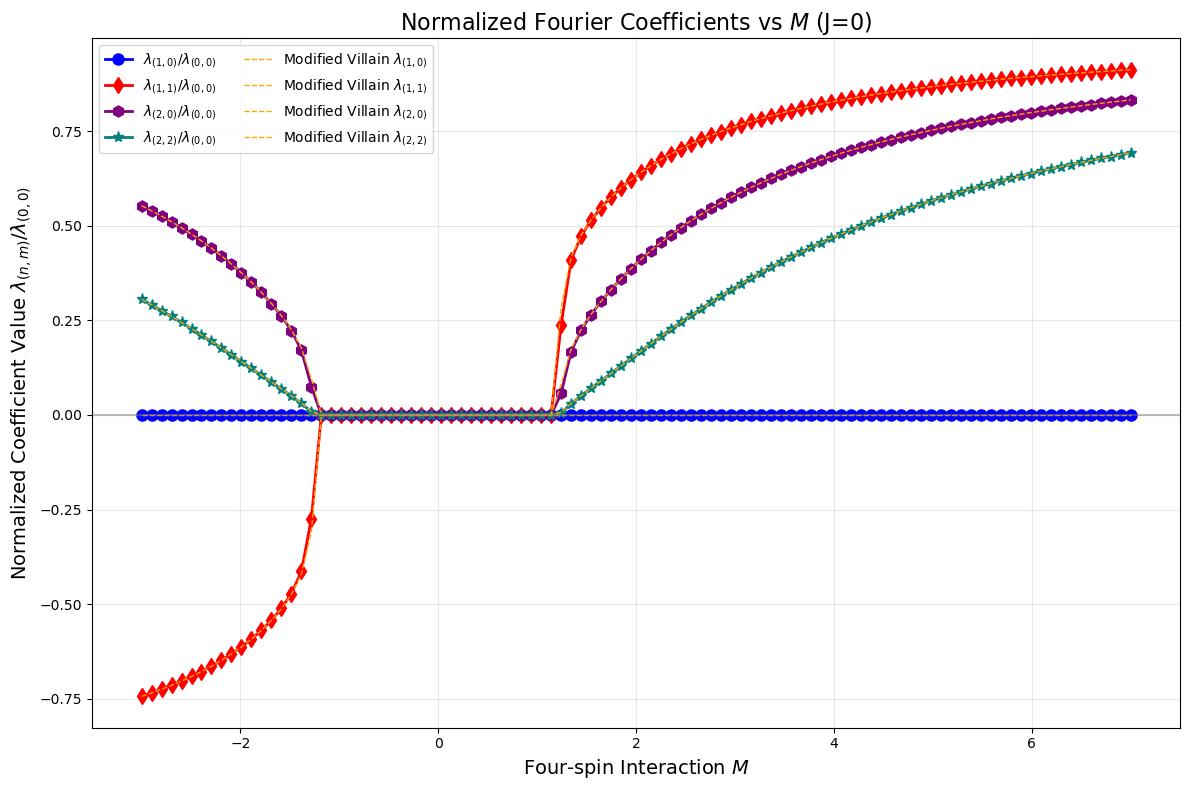

In [33]:
M_values = np.linspace(-3.0, 7.0, 100)

# Run analysis for fixed J=1.0
#results = analyze_coefficients_vs_M_parallel(M_values, J=0, n_max=20, n_steps=10, b=3, d=2, n_workers=4)

# Plot coefficient comparison with Villain predictions
fig = plot_m_villain_comparison(results, coeffs_to_show=['(1,0)', '(1,1)', '(2,0)', '(2,2)'], figsize=(12, 8))
plt.savefig("fixed-line_fixed-M.png", dpi=200)
plt.show()